In [2]:
import h5py
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
from pyrsimg import readTiff, imgShow,second_to_dyr,geo2imagexy
import pandas as pd
import re
from datetime import datetime,timedelta
from shapely.geometry import Point
from shapely.geometry import Polygon
import geopandas as gpd
from skimage.transform import resize
import seaborn as sns
from matplotlib.ticker import FuncFormatter
import threading
from concurrent.futures import ThreadPoolExecutor

In [3]:
path_atl13 = r'E:\lakes\NamCo\readout\ATL13_20192023.h5'
path_rsimg = r'E:\lakes\NamCo\NamCo.tif'
path_vec=r"E:\lakes\NamCo\inward_buffered_lake_WGS84.gpkg"

In [4]:
!h5ls $path_atl13


beam_type                Dataset {104345}
h                        Dataset {104345}
lat                      Dataset {104345}
lon                      Dataset {104345}
orbit_type               Dataset {104345}
qf_bckgrd                Dataset {104345}
qf_bias_em               Dataset {104345}
qf_bias_fit              Dataset {104345}
rgt                      Dataset {104345}
spot                     Dataset {104345}
stdev_water_surf         Dataset {104345}
t_dyr                    Dataset {104345}


In [5]:
base_time = datetime(2018,1,1,0,0,0,0)
with h5py.File(path_atl13,"r") as setp_atl13:
    #基本信息
    elev=setp_atl13["h"][:]
    lat=setp_atl13["lat"][:]
    lon=setp_atl13["lon"][:]
    time=setp_atl13["t_dyr"][:]
    # cycle=setp_atl13["cycle"][:]
    orbit=setp_atl13["orbit_type"][:]
    rgt=setp_atl13["rgt"][:]
    #质量信息
    qf_bckgrd=setp_atl13["qf_bckgrd"][:]
    qf_bias_em=setp_atl13["qf_bias_em"][:]
    qf_bias_fit=setp_atl13["qf_bias_fit"][:]
    stdev_water_surf=setp_atl13["stdev_water_surf"][:]

#remote sensing image
rsimg = readTiff(path_rsimg)
vec=gpd.read_file(path_vec)

    

In [94]:
rgt

array([797., 797., 797., ..., 942., 942., 942.], dtype=float32)

In [30]:
# qf_bckgrd[0:50]
# qf_bias_em[0:300]
# qf_bias_fit[0:300]
# stdev_water_surf

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 1.0, 'icesat2')

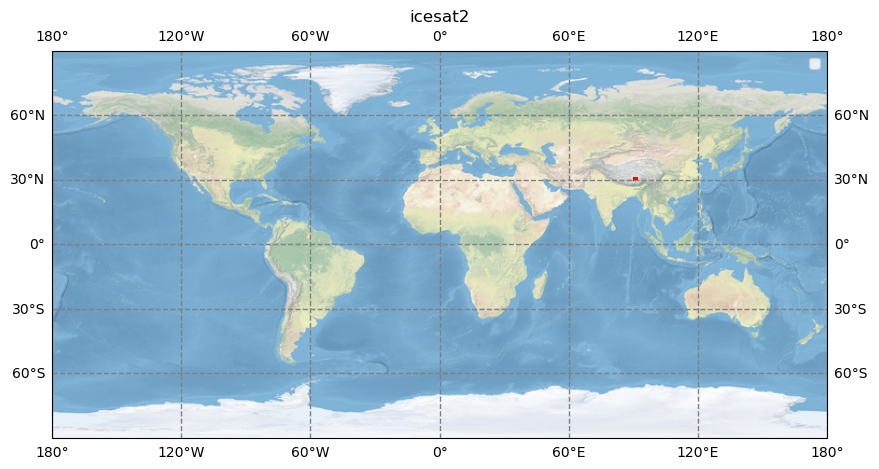

In [6]:
proj = ccrs.PlateCarree(central_longitude=0.0)
fig = plt.figure(figsize=(10, 10))
# orbit_isat = 'cycle_'+str(cycle)+'-track_'+str(track)
ax3 = fig.add_subplot(111, projection=proj); 
ax3.stock_img()
ax3.set_xlim(left=-180,right=180)
ax3.set_ylim(bottom=-90,top=90)
ax3.plot(lon,lat,marker='.',markersize=1,linewidth=0.0,color='red')
ax3.gridlines(draw_labels=True,linewidth=1,color='gray',linestyle='--')
ax3.legend()
plt.title('icesat2')

<Axes: >

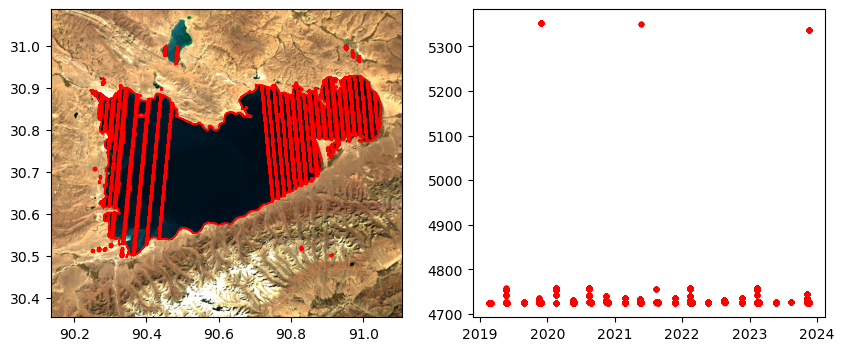

In [7]:
fig,ax=plt.subplots(1,2,figsize=(10,4))
imgShow(rsimg.array,extent=rsimg.geoextent,clip_percent=5,ax=ax[0])
ax[0].scatter(lon,lat,s=1.5,color='red')
ax[1].plot(time,elev,'r.')
elev.mean() 
vec.plot(ax=ax[0],facecolor="none",edgecolor="red")

In [8]:
# 读取其中的第一个图层或指定图层
vec=gpd.read_file(path_vec)

# 假设我们使用第一个几何对象来定义范围
boundary = vec.geometry[0]


# 假设 vec.geometry[0] 是一个多边形
# vec.geometry[0] = ...

# 创建一个用于存储结果的数组
ids_range = np.zeros(shape=(lon.shape))


In [9]:
# 定义处理函数
def process_points(lon_values, lat_values, start_idx, end_idx):
    for i in range(start_idx, end_idx):
        point = Point(lon_values[i], lat_values[i])
        if vec.geometry[0].contains(point):
            ids_range[i] = 1

# 将数据分成多个组
def split_data(data, num_groups):
    group_size = len(data) // num_groups
    return [(i * group_size, (i + 1) * group_size) for i in range(num_groups)]

# 设置线程数
num_threads = 4  # 根据需要调整线程数
data_groups = split_data(lon, num_threads)

# 使用线程池并行处理数据
with ThreadPoolExecutor(max_workers=num_threads) as executor:
    futures = []
    for start_idx, end_idx in data_groups:
        futures.append(executor.submit(process_points, lon, lat, start_idx, end_idx))

    # 等待所有线程完成
    for future in futures:
        future.result()

print("处理完成,ids_range:", ids_range)

处理完成,ids_range: [1. 1. 1. ... 0. 0. 0.]


In [35]:
# ###筛选范围内激光点
# ids_range=np.zeros(shape=(lon.shape))
# for i,lon_value in enumerate(lon):
#   point =Point(lon_value,lat[i])
#   if vec.geometry[0].contains(point):
#     ids_range[i]=1
# # ids_range[0:200]

In [10]:
#确保 ids_range 是布尔数组
ids_range = ids_range.astype(bool)
elev_range=elev[ids_range==1]
lon_range=lon[ids_range==1]
lat_range=lat[ids_range==1]
time_range=time[ids_range==1]
orbit_range=orbit[ids_range==1]
rgt_range=rgt[ids_range==1]
qf_bckgrd_range=qf_bckgrd[ids_range==1]
qf_bias_em_range=qf_bias_em[ids_range==1]
qf_bias_fit_range=qf_bias_fit[ids_range==1]
stdev_water_surf_range=stdev_water_surf[ids_range==1]


In [11]:
# 假设 time_range 等变量已经定义，构建 DataFrame
df = pd.DataFrame({
    "time": time_range,
    "elev": elev_range,
    "lat": lat_range,
    "lon": lon_range,
    "orbit":orbit_range,
    "rgt":rgt_range,
    "qf_bckgrd": qf_bckgrd_range,
    "qf_bias_em": qf_bias_em_range,
    "qf_bias_fit": qf_bias_fit_range,
    "stdev_water_surf": stdev_water_surf_range,
})

# 添加过滤条件
df_filtered = df[
    (~df['qf_bckgrd'].isin([6, 127])) &  # 删除 qf_bckgrd = 6 和 127 的数据
    (~df["qf_bias_em"].isin([-3, 3,4])) &  # 删除 qf_bias_em = -3 和 3 的数据
    (~df["qf_bias_fit"].isin([-3, 3])) &  # 删除 qf_bias_fit = -3 和 3 的数据
    (df["stdev_water_surf"] <= 2)  # 删除 stdev_water_surf > 2 的数据
]

# 输出过滤后的数据，返回 df_filtered
# print("Filtered data:")
# print(df_filtered)  # 输出过滤后的 DataFrame

# 打印过滤后的 DataFrame 的行数
print("Number of rows in df_filtered:", len(df_filtered))

Number of rows in df_filtered: 98594


In [12]:
def iqr_mad_outliers_by_time(df, column, time_column='time'):
    """
    使用四分位间距法 (IQR) 和中位数绝对偏差法 (MAD) 按照相同的时间段对数据进行筛选。
    
    参数：
    - df: DataFrame,包含需要筛选的数据。
    - column: str,需进行筛选的列名。
    - time_column: str,时间列名,默认为 'time'。
    
    返回：
    - filtered_df: 筛选后的数据（同时满足 IQR 和 MAD 条件）。
    - outliers_df: 筛选出的离群值数据。
    """
    # 存储筛选后的数据和离群值
    filtered_rows = []
    outliers_rows = []
    
    # 按照 time 列分组
    for _, group in df.groupby(time_column):
        # **四分位间距法 (IQR)**：
        q1 = group[column].quantile(0.25)
        q3 = group[column].quantile(0.75)
        iqr = q3 - q1
        lower_iqr = q1 - 1.5 * iqr
        upper_iqr = q3 + 1.5 * iqr

        # **中位数绝对偏差法 (MAD)**：
        median = group[column].median()
        mad = (group[column] - median).abs().median()
        mad_threshold = 3 * mad  # 通常选择 3 倍的 MAD 作为离群值判断标准
        lower_mad = median - mad_threshold
        upper_mad = median + mad_threshold

        # 筛选满足 IQR 和 MAD 条件的数据
        filtered_group = group[
            (group[column] >= max(lower_iqr, lower_mad)) & 
            (group[column] <= min(upper_iqr, upper_mad))
        ]
        
        # 筛选离群值
        outliers_group = group[
            (group[column] < max(lower_iqr, lower_mad)) | 
            (group[column] > min(upper_iqr, upper_mad))
        ]
        
        # 将筛选后的数据和离群值分别添加到列表中
        filtered_rows.append(filtered_group)
        outliers_rows.append(outliers_group)

    # 将结果合并为 DataFrame
    filtered_df = pd.concat(filtered_rows).sort_index()
    outliers_df = pd.concat(outliers_rows).sort_index()

    return filtered_df, outliers_df


In [13]:
def filter_data_by_latitude_groups(dataframe, value_column, latitude_column, latitude_interval, percentile):
    """
    将数据按纬度划分为指定的区间范围，并在每个区间内筛选出值大于指定百分位数的数据点。
    
    参数：
        dataframe (pd.DataFrame): 数据框
        value_column (str): 值所在列的列名
        latitude_column (str): 纬度所在列的列名
        latitude_interval (float): 纬度分组的区间大小 (如 0.1)
        percentile (float): 百分位数阈值 (0-100)
        
    返回：
        pd.DataFrame: 筛选后的数据框，包含所有满足条件的数据点
    """
    # 创建一个新的列，将纬度按 interval 划分为区间组
    dataframe['latitude_group'] = ((dataframe[latitude_column] // latitude_interval) * latitude_interval).round(2)
    
    # 定义存储筛选结果的列表
    filtered_results = []
    
    # 按纬度分组进行操作
    grouped = dataframe.groupby('latitude_group')
    for group_name, group_data in grouped:
        # 计算当前组中值列的第 percentile 百分位数
        threshold = group_data[value_column].quantile(percentile / 100)
        # 筛选大于百分位数的数据
        filtered_group = group_data[group_data[value_column] > threshold]
        # 将结果存储到列表中
        filtered_results.append(filtered_group)
    
    # 合并所有筛选结果为一个 DataFrame
    result = pd.concat(filtered_results, ignore_index=True)
    
    # 删除辅助列 latitude_group
    result.drop(columns=['latitude_group'], inplace=True)
    
    return result


In [14]:
# 先按纬度区间筛选数据
filtered_data_by_latitude = filter_data_by_latitude_groups(
    dataframe=df,
    value_column='elev',
    latitude_column='lat',
    latitude_interval=0.1,
    percentile=62
)

# 然后进行异常值检测
filtered_data, outliers_data = iqr_mad_outliers_by_time(filtered_data_by_latitude, column='elev')

# 查看结果
print("Filtered Data:")
print(filtered_data)

print("\nOutliers Data:")
print(outliers_data)

# 查看行数
print("\nNumber of rows in filtered data:", len(filtered_data))
print("Number of rows in outliers data:", len(outliers_data))

Filtered Data:
              time         elev        lat        lon  orbit    rgt  \
0      2019.879761  4726.103027  30.599360  90.440422    0.0  797.0   
2      2019.879761  4726.109863  30.597252  90.440186    0.0  797.0   
3      2019.879761  4726.102539  30.596407  90.440086    0.0  797.0   
4      2019.879761  4726.118164  30.595638  90.440002    0.0  797.0   
5      2019.879761  4726.115723  30.594852  90.439911    0.0  797.0   
...            ...          ...        ...        ...    ...    ...   
37958  2023.884033  4725.952148  30.917542  90.895317    1.0  942.0   
37959  2023.884033  4725.981934  30.917727  90.895302    1.0  942.0   
37960  2023.884033  4725.959961  30.918253  90.895248    1.0  942.0   
37961  2023.884033  4725.987305  30.918398  90.895233    1.0  942.0   
37962  2023.884033  4725.949707  30.918558  90.895218    1.0  942.0   

       qf_bckgrd  qf_bias_em  qf_bias_fit  stdev_water_surf  
0            2.0         0.0          0.0             0.115  
2       

In [129]:
# # 应用函数进行筛选
# filtered_data, outliers_data = iqr_mad_outliers_by_time(df_filtered, column='elev')

# # 查看结果
# print("Number of rows in filtered data:", len(filtered_data))  # 行数

# print("Number of rows in Outliers data:", len(outliers_data))  # 行数

Number of rows in filtered data: 91239
Number of rows in Outliers data: 7355


In [15]:
print(filtered_data.columns)


Index(['time', 'elev', 'lat', 'lon', 'orbit', 'rgt', 'qf_bckgrd', 'qf_bias_em',
       'qf_bias_fit', 'stdev_water_surf'],
      dtype='object')


In [101]:
# # 按照轨道分类计算平均值
# rgt_means = filtered_data.groupby('rgt').mean()

# # # 查看结果
# print(rgt_means)

# # 特定列的平均值，可以指定列名
# rgt_elev_mean = filtered_data.groupby('rgt')['elev'].mean()

# # 查看特定列的结果
# print(rgt_elev_mean)

              time         elev        lat        lon     orbit  qf_bckgrd  \
rgt                                                                          
797.0  2021.134766  4725.873047  30.726889  90.339622  0.000000   0.822727   
942.0  2021.864624  4725.829590  30.820814  90.888557  0.999955   0.865155   

       qf_bias_em  qf_bias_fit  stdev_water_surf  
rgt                                               
797.0   -0.130592     0.278938          0.031543  
942.0   -0.297297     0.273434          0.057967  


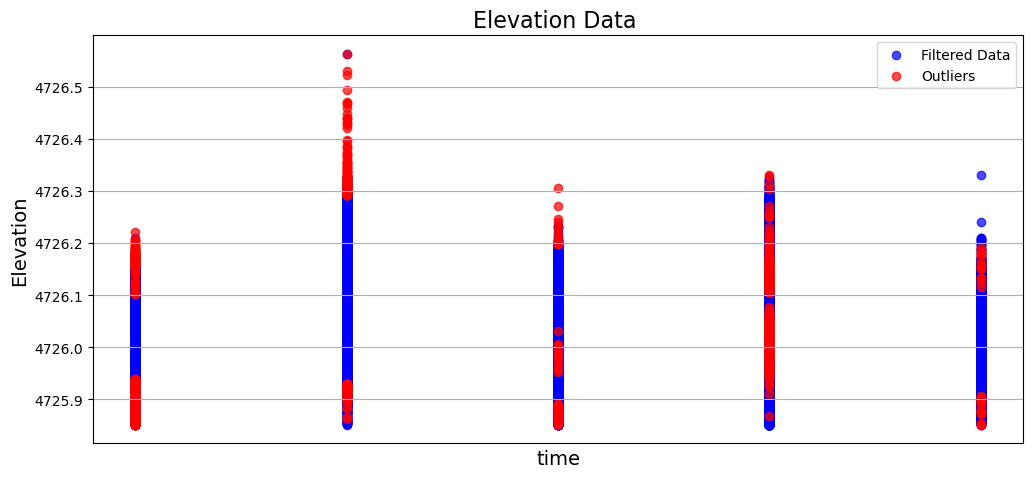

In [16]:
plt.figure(figsize=(12, 6))

# 筛选后的数据 (按时间绘制)
plt.scatter(pd.to_datetime(filtered_data['time']), filtered_data['elev'], color='blue', label='Filtered Data', alpha=0.7)

# 离群值 (按时间绘制)
plt.scatter(pd.to_datetime(outliers_data['time']), outliers_data['elev'], color='red', label='Outliers', alpha=0.7)

plt.title("Elevation Data ", fontsize=16)
plt.xlabel("time", fontsize=14)
plt.ylabel("Elevation", fontsize=14)
plt.legend()
plt.grid(True)
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m-%d %H:%M:%S'))
plt.gcf().autofmt_xdate()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


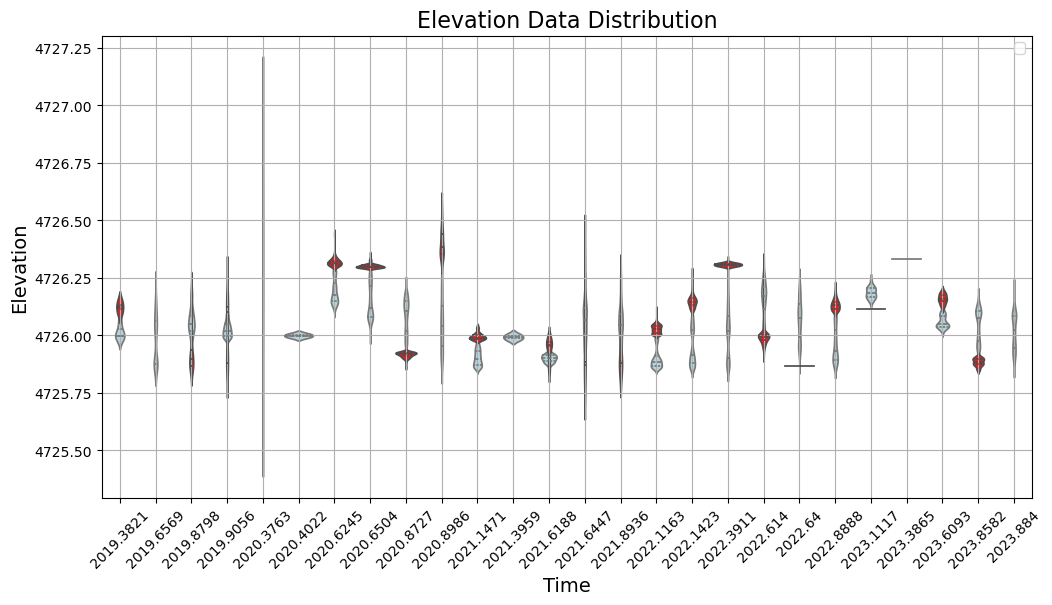

In [19]:
# 假设你希望绘制 'elev' 列的小提琴图
plt.figure(figsize=(12, 6))

# 绘制小提琴图，data 为你希望绘制的数据，y 为要绘制的变量
sns.violinplot(data=filtered_data, x='time', y='elev', inner="quart", color='lightblue')

# 如果需要，可以添加离群值数据
sns.violinplot(data=outliers_data, x='time', y='elev', inner="quart", color='red')

plt.title("Elevation Data Distribution", fontsize=16)
plt.xlabel("Time", fontsize=14)
plt.ylabel("Elevation", fontsize=14)
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)

plt.show()

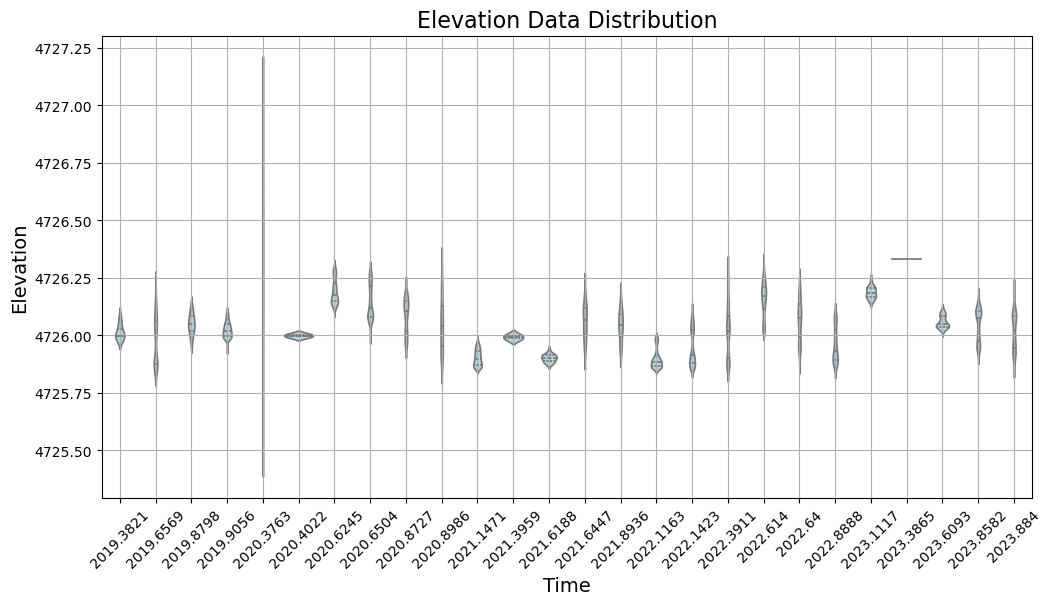

In [20]:
# 假设你希望绘制 'elev' 列的小提琴图
plt.figure(figsize=(12, 6))

# 绘制小提琴图，data 为你希望绘制的数据，y 为要绘制的变量
sns.violinplot(data=filtered_data, x='time', y='elev', inner="quart", color='lightblue')

plt.title("Elevation Data Distribution", fontsize=16)
plt.xlabel("Time", fontsize=14)
plt.ylabel("Elevation", fontsize=14)
plt.xticks(rotation=45)
plt.grid(True)

plt.show()

In [134]:
filtered_data


,time,elev,lat,lon,orbit,rgt,qf_bckgrd,qf_bias_em,qf_bias_fit,stdev_water_surf
0,2019.879761,4726.103027,30.599360,90.440422,0.0,797.0,2.0,0.0,0.0,0.115
2,2019.879761,4726.109863,30.597252,90.440186,0.0,797.0,2.0,0.0,0.0,0.090
3,2019.879761,4726.102539,30.596407,90.440086,0.0,797.0,2.0,0.0,0.0,0.090
4,2019.879761,4726.118164,30.595638,90.440002,0.0,797.0,2.0,0.0,0.0,0.090
5,2019.879761,4726.115723,30.594852,90.439911,0.0,797.0,2.0,0.0,0.0,0.090
...,...,...,...,...,...,...,...,...,...,...
37958,2023.884033,4725.952148,30.917542,90.895317,1.0,942.0,0.0,0.0,1.0,0.005
37959,2023.884033,4725.981934,30.917727,90.895302,1.0,942.0,0.0,0.0,1.0,0.005
37960,2023.884033,4725.959961,30.918253,90.895248,1.0,942.0,0.0,0.0,1.0,0.005
37961,2023.884033,4725.987305,30.918398,90.895233,1.0,942.0,0.0,0.0,1.0,0.005


In [42]:
# filtered_data.to_csv(r"E:\lakes\NamCo\readout\filtered_data.csv",index=False)

In [135]:
def decimal_to_date(decimal_time):
    year=int(decimal_time)
    remainder=decimal_time-year
    days_in_year=remainder*365.25
    date = pd.Timestamp(year=year, month=1, day=1) + pd.Timedelta(days=days_in_year)
    return date

In [139]:
# # 假设 df 已经包含了 "date" 和 "elev" 列
# df["date"] = filtered_data["time"].apply(decimal_to_date)  # 应用日期转换函数

# # 使用 groupby 对 date 列进行分组，然后计算 elev 列的均值
# df_grouped = df.groupby("date", as_index=False).agg({"elev": "mean"})

# # 保存到 CSV 文件
# # df_grouped.to_csv(r'e:\lakes\NamCo\readout\output_file_62.csv', index=False, encoding='utf-8')

# # 打印检查合并后的结果
# print(df_grouped)

                            date         elev
0  2019-05-20 13:18:50.273437500  4725.613770
1  2019-08-28 22:02:16.230468752  4725.685059
2  2019-11-18 07:58:57.597656248  4725.740723
3  2019-11-27 18:50:13.769531248  4725.854004
4  2020-05-17 11:01:14.707031250  4725.629395
5  2020-05-26 21:52:30.878906250  4725.785156
6  2020-08-16 02:28:11.015625000  4725.824219
7  2020-08-25 13:19:27.187500000  4725.891602
8  2020-11-14 17:55:07.324218752  4725.844727
9  2020-11-24 04:46:23.496093752  4725.885254
10 2021-02-23 17:25:56.542968750  4725.718750
11 2021-05-25 14:13:54.082031250  4726.074219
12 2021-08-15 00:10:35.449218752  4725.744141
13 2021-08-24 11:01:51.621093752  4725.887207
14 2021-11-23 08:54:01.406250000  4725.630859
15 2022-02-12 11:46:30.527343750  4725.681152
16 2022-02-21 23:41:58.945312500  4725.758301
17 2022-05-23 20:29:56.484375000  4725.802246
18 2022-08-13 06:26:37.851562500  4725.769531
19 2022-08-22 18:22:06.269531248  4725.722656
20 2022-11-21 15:10:03.808593752  

In [148]:
# 确保 time 列已经转换为日期格式
df["date"] = filtered_data["time"].apply(decimal_to_date)

# 提取年份和月份并添加到新列
df["year"] = df["date"].dt.year   # 提取年份
df["month"] = df["date"].dt.month # 提取月份

# 按年份和月份，以及轨道类型 rgt 分组，计算 elev 列的均值
df_grouped = df.groupby(["year", "month", "rgt"], as_index=False).agg({
    "elev": "mean"  # 计算 elev 列的均值
})

# 查看分组后的数据（如果需要）
# print(df_grouped)

# 计算每年每月的平均值（对所有轨道类型的均值）
df_monthly_avg = df_grouped.groupby(["year", "month"], as_index=False).agg({
    "elev": "mean"  # 计算相同年份和月份内的 elev 均值
})

# 查看结果
print(df_monthly_avg)

# 将分组后的数据保存为 CSV 文件
df_grouped.to_csv(r'e:\lakes\NamCo\readout\output_file_62.csv', index=False, encoding='utf-8')

      year  month         elev
0   2019.0    5.0  4725.613770
1   2019.0    8.0  4725.685059
2   2019.0   11.0  4725.720703
3   2020.0    5.0  4725.707031
4   2020.0    8.0  4725.945312
5   2020.0   11.0  4725.815918
6   2021.0    2.0  4725.718750
7   2021.0    5.0  4726.074219
8   2021.0    8.0  4725.876953
9   2021.0   11.0  4725.929688
10  2022.0    2.0  4725.735840
11  2022.0    5.0  4725.750000
12  2022.0    8.0  4725.759766
13  2022.0   11.0  4725.867188
14  2023.0    2.0  4726.095215
15  2023.0    5.0  4726.294434
16  2023.0    8.0  4726.110352
17  2023.0   11.0  4726.019531


In [150]:
# 确保 time 列已经转换为日期格式
df["date"] = filtered_data["time"].apply(decimal_to_date)

# 提取年份和月份并合并为一个新的列
df["year"] = df["date"].dt.year  # 提取年份
df["month"] = df["date"].dt.month  # 提取月份

# 创建一个新的日期列，格式为 'YYYY-MM'
df["year_month"] = df["date"].dt.to_period("M")

# 按年份和月份，以及轨道类型 rgt 分组，计算 elev 列的均值
df_grouped = df.groupby(["date", "rgt"], as_index=False).agg({
    "elev": "mean"  # 计算 elev 列的均值
})

# 查看分组后的数据（如果需要）
# print(df_grouped)

# 计算每年每月的平均值（对所有轨道类型的均值）
df_monthly_avg = df_grouped.groupby("date", as_index=False).agg({
    "elev": "mean"  # 计算相同年份和月份内的 elev 均值
})

# 查看结果
print(df_monthly_avg)

# 将分组后的数据保存为 CSV 文件
df_grouped.to_csv(r'e:\lakes\NamCo\readout\output_file_62.csv', index=False, encoding='utf-8')

                            date         elev
0  2019-05-20 13:18:50.273437500  4725.613770
1  2019-08-28 22:02:16.230468752  4725.685059
2  2019-11-18 07:58:57.597656248  4725.708008
3  2019-11-27 18:50:13.769531248  4725.903809
4  2020-05-17 11:01:14.707031250  4725.629395
5  2020-05-26 21:52:30.878906250  4725.785156
6  2020-08-16 02:28:11.015625000  4725.732422
7  2020-08-25 13:19:27.187500000  4725.949707
8  2020-11-14 17:55:07.324218752  4725.813477
9  2020-11-24 04:46:23.496093752  4726.066406
10 2021-02-23 17:25:56.542968750  4725.718750
11 2021-05-25 14:13:54.082031250  4726.074219
12 2021-08-15 00:10:35.449218752  4725.744141
13 2021-08-24 11:01:51.621093752  4725.887207
14 2021-11-23 08:54:01.406250000  4725.929688
15 2022-02-12 11:46:30.527343750  4725.610840
16 2022-02-21 23:41:58.945312500  4725.770508
17 2022-05-23 20:29:56.484375000  4725.750000
18 2022-08-13 06:26:37.851562500  4725.779297
19 2022-08-22 18:22:06.269531248  4725.737305
20 2022-11-21 15:10:03.808593752  

In [66]:
#提取年、季度、月份信息
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['quarter'] = df['date'].dt.to_period('Q')

In [67]:
# 按年分组并计算平均值
year_avg = df.groupby('year')['elev'].mean().reset_index()
# 按季度分组并计算平均值
quarter_avg = df.groupby('quarter')['elev'].mean().reset_index()
# 按月分组并计算平均值
month_avg = df.groupby(['year', 'month'])['elev'].mean().reset_index()
print(month_avg)

      year  month         elev
0   2019.0    5.0  4725.613770
1   2019.0    8.0  4725.685059
2   2019.0   11.0  4725.745605
3   2020.0    5.0  4725.707031
4   2020.0    8.0  4725.879883
5   2020.0   11.0  4725.852051
6   2021.0    2.0  4725.718750
7   2021.0    5.0  4726.074219
8   2021.0    8.0  4725.876953
9   2021.0   11.0  4725.630859
10  2022.0    2.0  4725.720215
11  2022.0    5.0  4725.802246
12  2022.0    8.0  4725.747559
13  2022.0   11.0  4725.875488
14  2023.0    2.0  4726.095215
15  2023.0    5.0  4726.294434
16  2023.0    8.0  4726.110352
17  2023.0   11.0  4725.990723


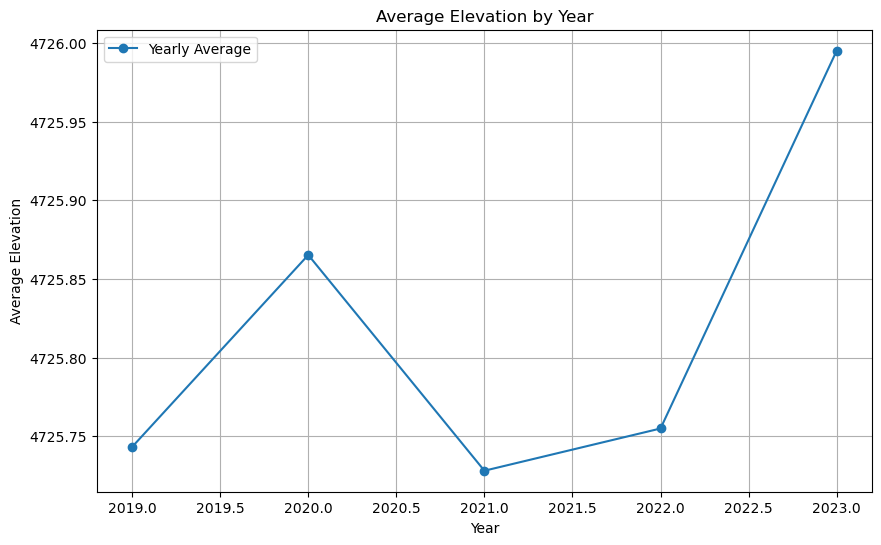

In [68]:
##年际变化
fig= plt.subplots(figsize=(10, 6))
plt.plot(year_avg["year"],year_avg["elev"],marker='o', label='Yearly Average')
plt.title('Average Elevation by Year')
plt.xlabel('Year')
plt.ylabel('Average Elevation')
plt.grid(True)
plt.legend()
plt.show()



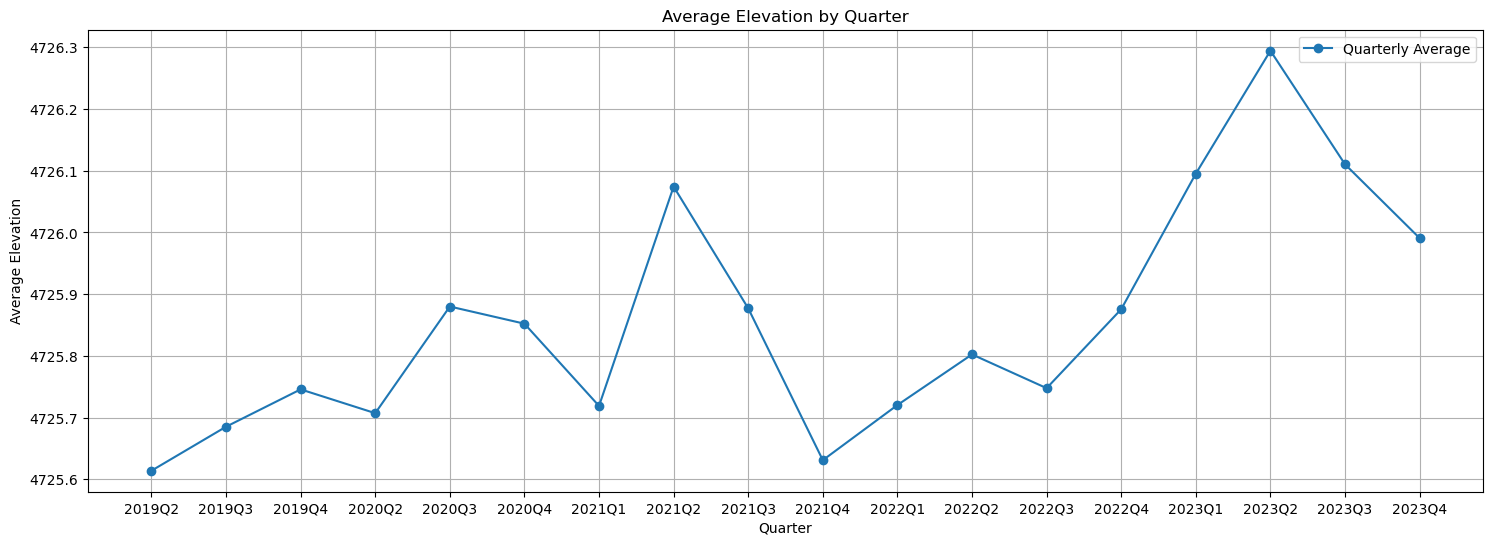

In [69]:
#季度变化
plt.figure(figsize=(18, 6))
plt.plot(quarter_avg['quarter'].astype(str), quarter_avg['elev'], marker='o', label='Quarterly Average')
plt.title('Average Elevation by Quarter')
plt.xlabel('Quarter')
plt.ylabel('Average Elevation')
plt.grid(True)
plt.legend()
plt.show()


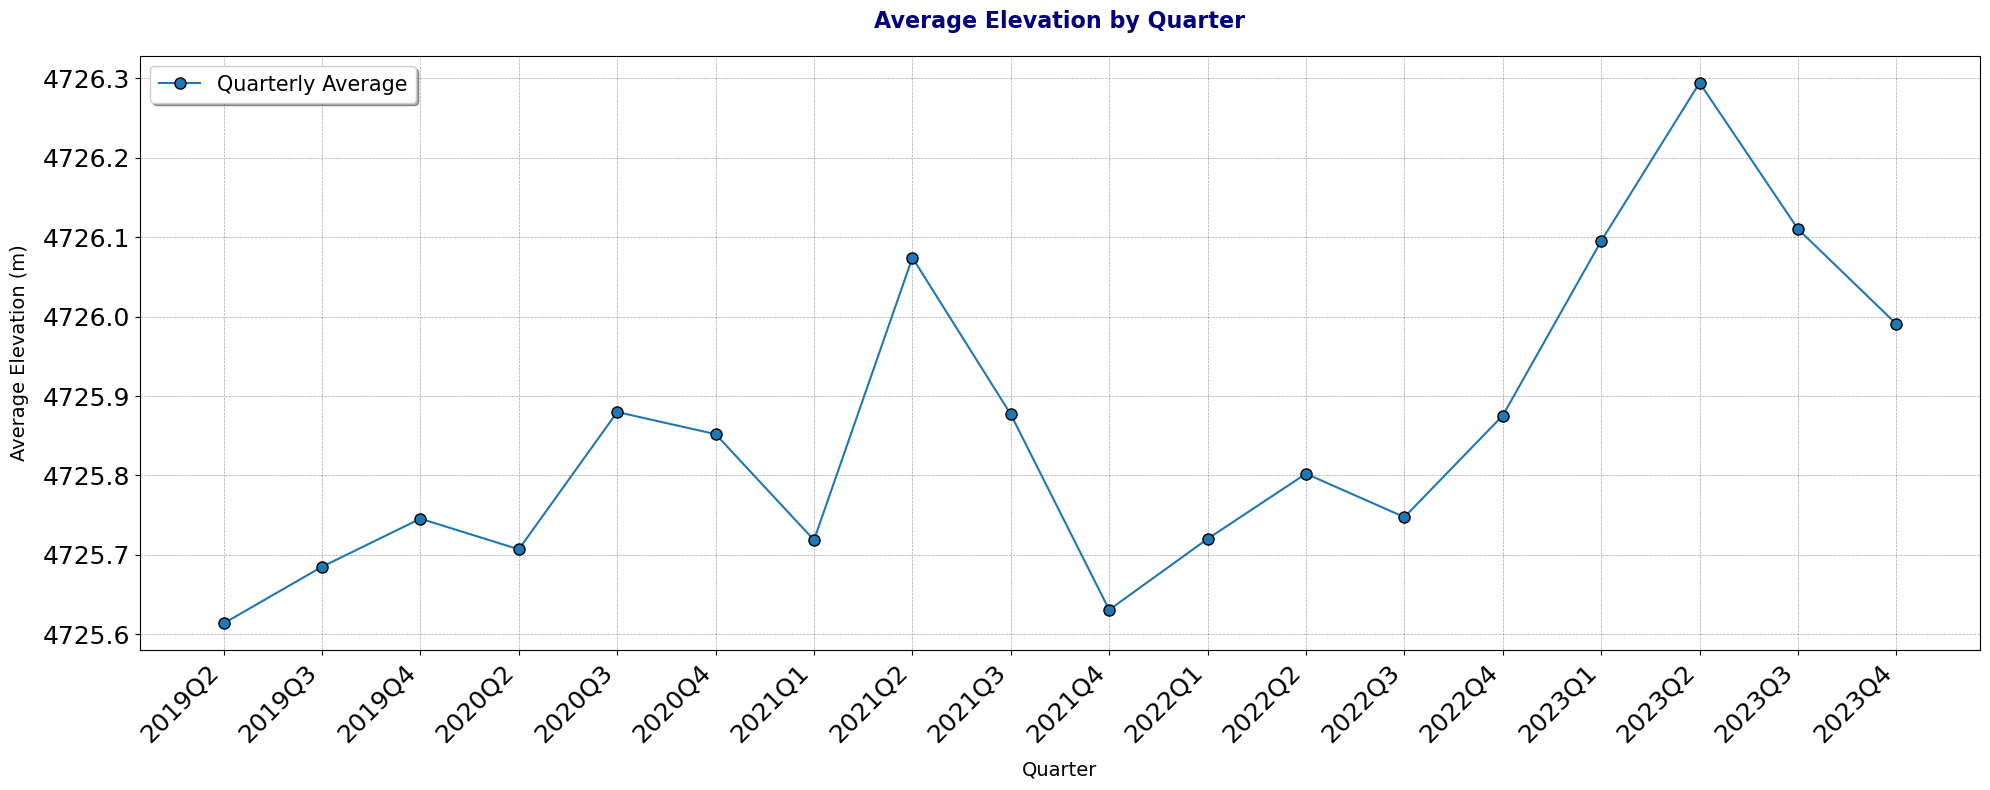

In [70]:
# 手动设置图形样式
plt.figure(figsize=(20, 8))  # 调整图形大小

# 绘制数据
plt.plot(
    quarter_avg['quarter'].astype(str), 
    quarter_avg['elev'], 
    marker='o', 
    linestyle='-', 
    color='#1f77b4',  # 设置线条颜色
    markerfacecolor='#1f77b4',  # 设置标记填充颜色
    markeredgecolor='black',  # 设置标记边框颜色
    markersize=8,  # 调整标记大小
    label='Quarterly Average'
)

# 图形标题和标签
plt.title('Average Elevation by Quarter', fontsize=16, fontweight='bold', color='navy', pad=20)
plt.xlabel('Quarter', fontsize=14, labelpad=10)
plt.ylabel('Average Elevation (m)', fontsize=14, labelpad=10)

# 设置网格样式
plt.grid(visible=True, linestyle='--', linewidth=0.5, color='gray', alpha=0.7)

# 添加图例
plt.legend(fontsize=15, loc='best', frameon=True, shadow=True)

# 调整 x 轴刻度
plt.xticks(fontsize=18, rotation=45, ha='right')  # 旋转 x 轴标签
plt.yticks(fontsize=18)

# 自动调整布局，避免标签被裁剪
plt.tight_layout()

# 显示图形
plt.show()


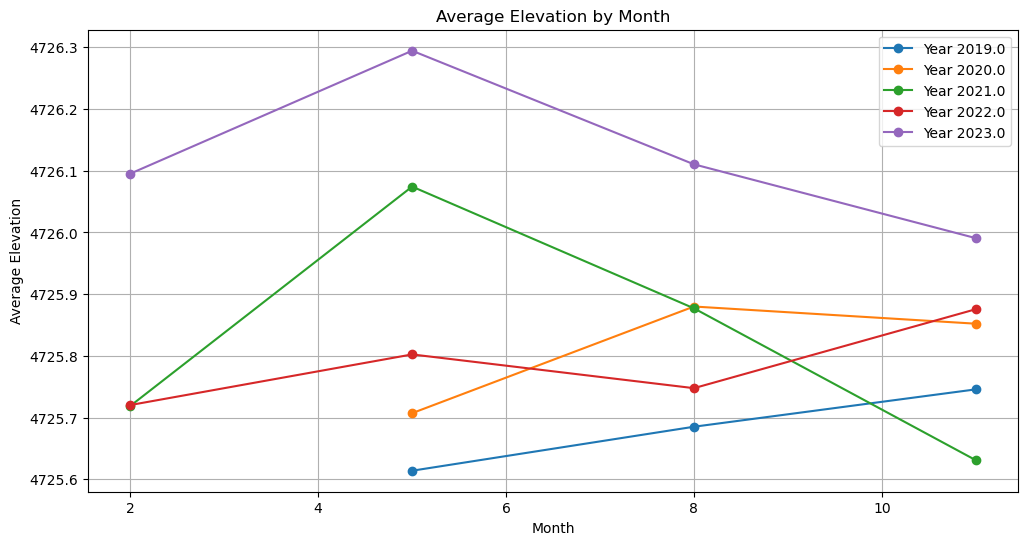

In [71]:
#月度变化
plt.figure(figsize=(12, 6))
for year in month_avg['year'].unique():
    year_data = month_avg[month_avg['year'] == year]
    plt.plot(year_data['month'], year_data['elev'], marker='o', label=f'Year {year}')

plt.title('Average Elevation by Month')
plt.xlabel('Month')
plt.ylabel('Average Elevation')
plt.grid(True)
plt.legend()
plt.show()